# Deep Fashion Multi-task Learning


## Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`. This is the default version in Google Colab.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.15 (default, Oct 12 2022, 19:14:55) 
torch 1.12.1+cu113
torchvision 0.13.1+cu113


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

## Unzip Data

In [ ]:
!unzip -qq ./drive/My\ Drive/deep_fashion.zip

In [ ]:
# !unzip -qq /content/drive/MyDrive/中山深度/deep_fashion.zip

replace deep_fashion/val/02039.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
data_folder = 'deep_fashion'

## Loading the dataset


### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn 
from sklearn.preprocessing import MultiLabelBinarizer

class FashionData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.category_label = []
        self.attribute_label = []
        self.onehot_attribute_label = [] # for a list of attribute_label just split already and continue to do the onehot encoding
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['file_path'])
                if mode != 'test':
                    self.category_label.append(row['category_label'])
                    self.attribute_label.append(row['attribute_label']) 

        for i, j in enumerate(self.attribute_label):
          if len(j) >= 3:
            self.onehot_attribute_label.append(self.attribute_label[i].split(' '))
          else:
            self.onehot_attribute_label.append(self.attribute_label[i])
        
        mlb = MultiLabelBinarizer(classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14'])
        self.onehot_attribute_label = mlb.fit_transform(self.onehot_attribute_label) 

    def __getitem__(self, index):
        attribute_label = [] # a list to store the one-hot encoding result
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data

        category_label = torch.tensor(int(self.category_label[index]))
        attribute_label = torch.tensor(self.onehot_attribute_label[index])

        return data, category_label, attribute_label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [ ]:
from torchvision import transforms

# For TRAIN
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    
    transforms.ColorJitter(brightness = 0.5),
    # transforms.RandomGrayscale(p = 0.5),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])
])

# For VAL, TEST
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])
])

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [ ]:
dataset_train = FashionData('train.csv', mode='train', transform=transforms_train)
dataset_val = FashionData('val.csv', mode='val', transform=transforms_test)
dataset_test = FashionData('test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train[0][0].size())
print("The first image's number of attributes: ", dataset_train.__getitem__(1)[1])
print("The first image's number of attributes: ", dataset_train.__getitem__(1)[2])
print("There are", len(dataset_train), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
The first image's number of attributes:  tensor(1)
The first image's number of attributes:  tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
There are 39092 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
# num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

In [ ]:
import torch.nn.functional as F
from torchvision import models

In [ ]:
class MultiTaskModel(nn.Module):
  def __init__(self):
      super(MultiTaskModel, self).__init__()
      self.model = models.resnet50(pretrained=True)

      # This sector will freez first two layers
      # layer = 0
      # for child in self.model.children():
        # layer += 1
        # if layer < 3:
          # for param in child.parameters():
            # param.requires_grad = False

      num_ftrs = self.model.fc.in_features
      self.model.fc = nn.Sequential(nn.Linear(num_ftrs, num_ftrs),
                                    nn.BatchNorm1d(num_ftrs),
                                    nn.ReLU(),
                                    nn.Linear(num_ftrs, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 512))


      self.fc1 = nn.Sequential(nn.ReLU(), 
                               nn.BatchNorm1d(512),
                               nn.Dropout(0.5),
                               nn.Linear(512, 512),
                               nn.ReLU(),
                               nn.Linear(512, 256),
                               nn.ReLU(),
                               nn.Linear(256, 10))

      self.fc2 = nn.Sequential(nn.ReLU(), 
                               nn.BatchNorm1d(512),
                               nn.Dropout(0.5),
                               nn.Linear(512, 512),
                               nn.ReLU(),
                               nn.Linear(512, 256),
                               nn.ReLU(),
                               nn.Linear(256, 15))
      
      # self.sigm = nn.Sigmoid()

      # self.fc1= nn.Sequential(
            # nn.Dropout(0.5),
            # nn.Linear(7*7*512, 2056),
            # nn.Linear(1000, 2048),
            # nn.ReLU(),

            # nn.Dropout(0.5),
            # nn.Linear(2048, 1024),
            # nn.ReLU(),

            # nn.Linear(1024, 10)
        # )
      
      # self.fc2= nn.Sequential(
            # nn.Dropout(0.5),
            # nn.Linear(7*7*512, 2056),
            # nn.Linear(1000, 2048),
            # nn.ReLU(),

            # nn.Dropout(0.5),
            # nn.Linear(2048, 1024),
            # nn.ReLU(),

            # nn.Linear(1024, 15)
        # )
      
  def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        
        out = self.model(x)
        # out = out.view(out.size()[0], -1)
        out1 = self.fc1(out)

        out2 = self.fc2(out)
        # out2 = self.sigm(out2)
  
        return out1, out2

In [ ]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [ ]:
model = MultiTaskModel()
model = model.to(device)
# print(model)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

###Test the model you had been created. 

In [ ]:
import torch
# 32 is batch_size
fake_x = torch.rand(32, 3, 224, 224) # generate fake data
fake_x = fake_x.to(device)

pred_cate, pred_attr = model(fake_x) # output of category and attribute
print(pred_cate.shape) # shape should be (batch, 10)
print(pred_attr.shape) # shape should be (batch, 15)

torch.Size([32, 10])
torch.Size([32, 15])


### Define loss and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.005, momentum = 0.9)
# optimizer1 = torch.optim.Adam(model.parameters(), lr=0.0005)  # throw param into optimizer some_optimier(param, lr=...)

criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)

In [ ]:
# This function is another way to calculate f1_score, a little adjust to fit your own situation if it's needed

# from sklearn import metrics
# def calculate_metrics(pred, target, threshold=0.5):
    # pred = np.array(pred > threshold, dtype=float)
    # f1_score = metrics.f1_score(y_true = target, y_pred = pred, average = 'samples')
    # return f1_score

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

In [ ]:
def train(input_data, model, criterion1, criterion2, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []

    total_pred = []
    attr_label_list = []

    total_count = 0
    acc_count = 0

    train_f1_score = 0

    for batch in input_data:
        images, cate_labels, attr_labels = batch # torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 16])
        images = images.to(device)
        cate_labels = cate_labels.to(device)
        attr_labels = attr_labels.to(device)
       
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        optimizer.zero_grad()

        out_cate, out_attr = model(images)

        total_pred.extend(out_attr.cpu().detach().numpy())
        attr_label_list.extend(attr_labels.cpu().detach().numpy())

        loss1 = criterion1(out_cate, cate_labels)
        loss2 = criterion2(out_attr, attr_labels.float())
        loss = 0.3 * loss1 + loss2
        loss.backward()

        optimizer.step()

        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        _, predicted_cate = torch.max(out_cate.data, 1) # the class with the highest value is what we choose as prediction
        total_count += cate_labels.size(0)
        acc_count += (predicted_cate == cate_labels).sum().item()

        out_attr = torch.sigmoid(out_attr) > 0.5

        train_f1_score += f1_score(attr_labels.to("cpu").to(torch.int).numpy(), out_attr.to("cpu").to(torch.int).numpy(), average="samples")

        loss_list.append(loss.item())

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    # train_f1_score = calculate_metrics(np.array(total_pred), np.array(attr_label_list))
    train_f1_score = train_f1_score / len(loss_list)

    return acc, loss, train_f1_score

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [ ]:
def val(input_data, model, criterion1, criterion2):
    model.eval()
    loss_list = []

    total_pred = []
    attr_label_list = []

    total_count = 0
    acc_count = 0
    val_f1_score = 0
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for batch in input_data:
            images, cate_labels, attr_labels = batch # torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 16])
            images = images.to(device)
            cate_labels = cate_labels.to(device)
            attr_labels = attr_labels.to(device)

            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            out_cate, out_attr = model(images)

            total_pred.extend(out_attr.cpu().detach().numpy())
            attr_label_list.extend(attr_labels.cpu().detach().numpy())

            loss1 = criterion1(out_cate, cate_labels)
            loss2 = criterion2(out_attr, attr_labels.float())
            loss = 0.3 * loss1 + loss2

            _, predicted_cate = torch.max(out_cate.data, 1)
            total_count += cate_labels.size(0)
            acc_count += (predicted_cate == cate_labels).sum().item()

            out_attr = torch.sigmoid(out_attr) > 0.5

            val_f1_score += f1_score(attr_labels.to("cpu").to(torch.int).numpy(), out_attr.to("cpu").to(torch.int).numpy(), average="samples")

            loss_list.append(loss.item())

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    # val_f1_score = calculate_metrics(np.array(total_pred), np.array(attr_label_list))
    val_f1_score = val_f1_score / len(loss_list)
    
    return acc, loss, val_f1_score

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [ ]:
max_epochs = 40
log_interval = 10 # print acc and loss in per log_interval time

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
train_f1_list = []
val_f1_list = []

early_stopping = EarlyStopping(patience=20, verbose=True)

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss, train_f1_score = train(train_loader, model, criterion1, criterion2, optimizer)
    val_acc, val_loss, val_f1_score = val(val_loader, model, criterion1, criterion2)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_f1_list.append(train_f1_score)
    val_f1_list.append(val_f1_score)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
        print('Training_f1_score: {:.6f}'.format(train_f1_score))
        print('Validation_f1_score: {:.6f}'.format(val_f1_score))

    early_stopping(val_loss, model)
          
    if early_stopping.early_stop:
      print("Early stopping")
      break

Validation loss decreased (inf --> 0.776859).  Saving model ...
Validation loss decreased (0.776859 --> 0.673746).  Saving model ...
Validation loss decreased (0.673746 --> 0.631561).  Saving model ...
Validation loss decreased (0.631561 --> 0.614309).  Saving model ...
Validation loss decreased (0.614309 --> 0.600229).  Saving model ...
Validation loss decreased (0.600229 --> 0.587256).  Saving model ...
Validation loss decreased (0.587256 --> 0.577690).  Saving model ...
Validation loss decreased (0.577690 --> 0.576086).  Saving model ...
Validation loss decreased (0.576086 --> 0.574692).  Saving model ...
==================== Epoch 10 ====================
Train Acc: 0.651719 Train Loss: 0.535756
  Val Acc: 0.637120   Val Loss: 0.568780
Training_f1_score: 0.315785
Validation_f1_score: 0.397557
Validation loss decreased (0.574692 --> 0.568780).  Saving model ...
Validation loss decreased (0.568780 --> 0.563347).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counte

In [ ]:
# save your well-trained state_dict of model (No need to run this cell if you already apply earlystopping)
# torch.save(model.state_dict(), 'NAME_OF_THIS_EXPERIMENT.pt')

#### Visualize accuracy and loss

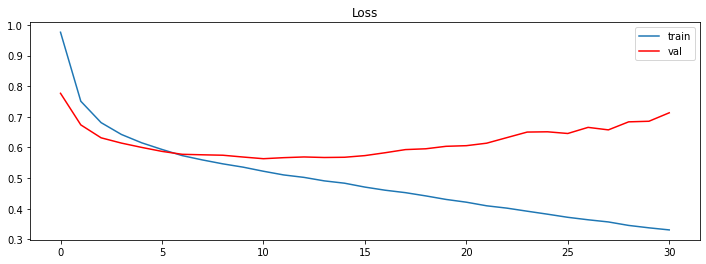

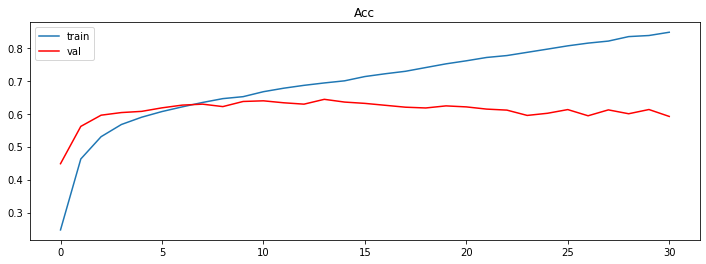

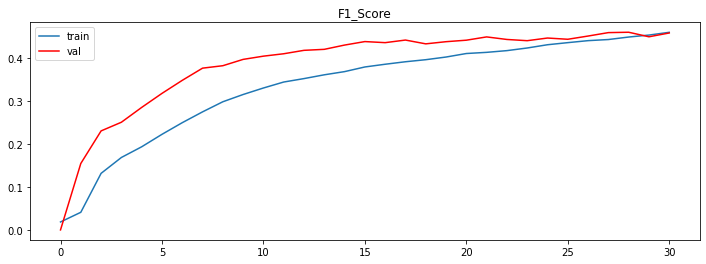

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_f1_list)), train_f1_list)
plt.plot(range(len(val_f1_list)), val_f1_list, c='r')
plt.legend(['train', 'val'])
plt.title('F1_Score')
plt.show()

### Predict Result

In [ ]:
# if you wanna load previous best model
ckpt = torch.load('checkpoint.pt') # (change the file name of the model if it's necessary)
model.load_state_dict(ckpt) 

<All keys matched successfully>

In [ ]:
def predict(input_data, model):
    model.eval()
    out_cate_list = []
    out_attr_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            out_cate, out_attr = model(images)
            _, predicted_cate = torch.max(out_cate.data, 1)

            # predicted_attr = out_attr > 0.5
            predicted_attr = torch.sigmoid(out_attr) > 0.5

            out_attr_list.extend(predicted_attr.to('cpu').numpy().tolist())
            out_cate_list.extend(predicted_cate.to('cpu').numpy().tolist())
    return out_cate_list, out_attr_list

In [ ]:
idx = 0
cate_csv, attr_csv = predict(test_loader, model)
res = []
with open('result_cate.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['Id', 'category_label'])
    writer.writeheader()
    for preds in cate_csv:
        idx+=1
        writer.writerow({'Id':idx, 'category_label':preds})

with open('result_attr.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['Id', 'attribute_label'])
    writer.writeheader()
    for preds in attr_csv:
        idx+=1
        for i in range(len(preds)):
            if preds[i] == 1:
                res.append(i)
        writer.writerow({'Id':idx, 'attribute_label':" ".join(map(str, res))})
        res.clear()

In [ ]:
# download the file to do the further processing

from google.colab import files
files.download("result_cate2.csv")
files.download("result_attr2.csv")

In [ ]:
# This cell just adjust the saving file as the require format

import pandas as pd

image_name_df = pd.read_csv("/content/deep_fashion/test.csv")
cate_df = pd.read_csv("/content/result_cate.csv")
attr_df = pd.read_csv("/content/result_attr.csv")

cate_df = pd.concat([image_name_df, cate_df], axis = 1)
attr_df = pd.concat([image_name_df, attr_df], axis = 1)

cate_df = cate_df.drop(["Id"], axis = 1)
attr_df = attr_df.drop(["Id"], axis = 1)

print(cate_df.sample(10))
print(attr_df.sample(10))

                         file_path  category_label
8101   deep_fashion/test/08102.jpg               0
3305   deep_fashion/test/03306.jpg               2
4931   deep_fashion/test/04932.jpg               1
5763   deep_fashion/test/05764.jpg               2
4921   deep_fashion/test/04922.jpg               0
10442  deep_fashion/test/10443.jpg               0
10943  deep_fashion/test/10944.jpg               4
3757   deep_fashion/test/03758.jpg               6
6013   deep_fashion/test/06014.jpg               9
10881  deep_fashion/test/10882.jpg               2
                        file_path attribute_label
2154  deep_fashion/test/02155.jpg               0
6647  deep_fashion/test/06648.jpg               0
5347  deep_fashion/test/05348.jpg               1
443   deep_fashion/test/00444.jpg               1
9847  deep_fashion/test/09848.jpg             3 8
8192  deep_fashion/test/08193.jpg             NaN
8024  deep_fashion/test/08025.jpg               1
943   deep_fashion/test/00944.jpg      

In [ ]:
# Save the final edited version

cate_df.to_csv('category_pred_result_resnet50.csv', index = False, header = True)
attr_df.to_csv('attribute_pred_result_resnet50.csv', index = False, header = True)